# Moving edge responses

This notebook introduces moving edge responses and the direction selectivity index (DSI). The DSI measures motion selectivity of cells to visual input.

**Select GPU runtime**

To run the notebook on a GPU select Menu -> Runtime -> Change runtime type -> GPU.

In [1]:
# @markdown **Check access to GPU**

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    import torch

    try:
        cuda_name = torch.cuda.get_device_name()
        print(f"Name of the assigned GPU / CUDA device: {cuda_name}")
    except RuntimeError:
        import warnings

        warnings.warn(
            "You have not selected Runtime Type: 'GPU' or Google could not assign you one. Please revisit the settings as described above or proceed on CPU (slow)."
        )

**Install Flyvis**

The notebook requires installing our package `flyvis`. You may need to restart your session after running the code block below with Menu -> Runtime -> Restart session. Then, imports from `flyvis` should succeed without issue.

In [2]:
# @markdown **Install Flyvis**
if IN_COLAB:
    !git clone https://github.com/TuragaLab/flyvis.git
    %cd /content/flyvis
    !pip install -e .[examples]

## Moving edge stimuli

To elicit moving edge responses and characterise the motion selectivity of neurons, experimenters show an ON or OFF edge moving in different cardinal directions. We generate and render these stimuli with the `MovingEdge` dataset.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch


from flyvis.datasets.moving_bar import MovingEdge
from flyvis.analysis.animations.hexscatter import HexScatter

In [4]:
# initialize dataset
# make the dataset
dataset = MovingEdge(
    offsets=[-10, 11],  # offset of bar from center in 1 * radians(2.25) led size
    intensities=[0, 1],  # intensity of bar
    speeds=[19],  # speed of bar in 1 * radians(5.8) / s
    height=80,  # height of moving bar in 1 * radians(2.25) led size
    post_pad_mode="continue",  # for post-stimulus period, continue with the last frame of the stimulus
    t_pre=1.0,  # duration of pre-stimulus period
    t_post=1.0,  # duration of post-stimulus period
    dt=1 / 200,  # temporal resolution of rendered video
    angles=list(np.arange(0, 360, 30)),  # motion direction (orthogonal to edge)
)

In [5]:
# view stimulus parameters
dataset.arg_df
# the dataset has four samples, one corresponding to each row

,angle,width,intensity,t_stim,speed
0,0,80,0,0.428766,19
1,0,80,1,0.428766,19
2,30,80,0,0.428766,19
3,30,80,1,0.428766,19
4,60,80,0,0.428766,19
5,60,80,1,0.428766,19
6,90,80,0,0.428766,19
7,90,80,1,0.428766,19
8,120,80,0,0.428766,19
9,120,80,1,0.428766,19


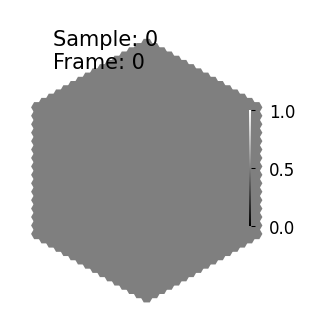

In [6]:
# visualize single sample
# %#matplotlib notebook
animation = HexScatter(
    dataset[3][None, ::25, None], vmin=0, vmax=1
)  # intensity=1, radius=6
animation.animate_in_notebook()

## Moving edge response

Now that we have generated the stimulus, we can use it to drive a trained connectome-constrained network.

In [7]:
from flyvis import results_dir
from flyvis.network import NetworkView

# model are already sorted by task error
# we take the best task-performing model from the pre-sorted ensemble
network_view = NetworkView(results_dir / "flow/0000/000")

[2024-12-08 19:36:19] network_view:122 Initialized network view at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/000


In [8]:
stims_and_resps = network_view.moving_edge_responses(dataset)

/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_responses/8aa5ae3c0c09b91f372ef03516814bd1/output.h5


We've now computed network moving edge responses for all cells in the network.

### Response traces
We can plot single-cell response traces with `stims_and_resps['responses'].custom.plot_traces()`. Here, we plot responses of T4c cells to edges with intensity 1 (ON edges).

Text(0.5, 1.0, 'T4c responses to moving edge')

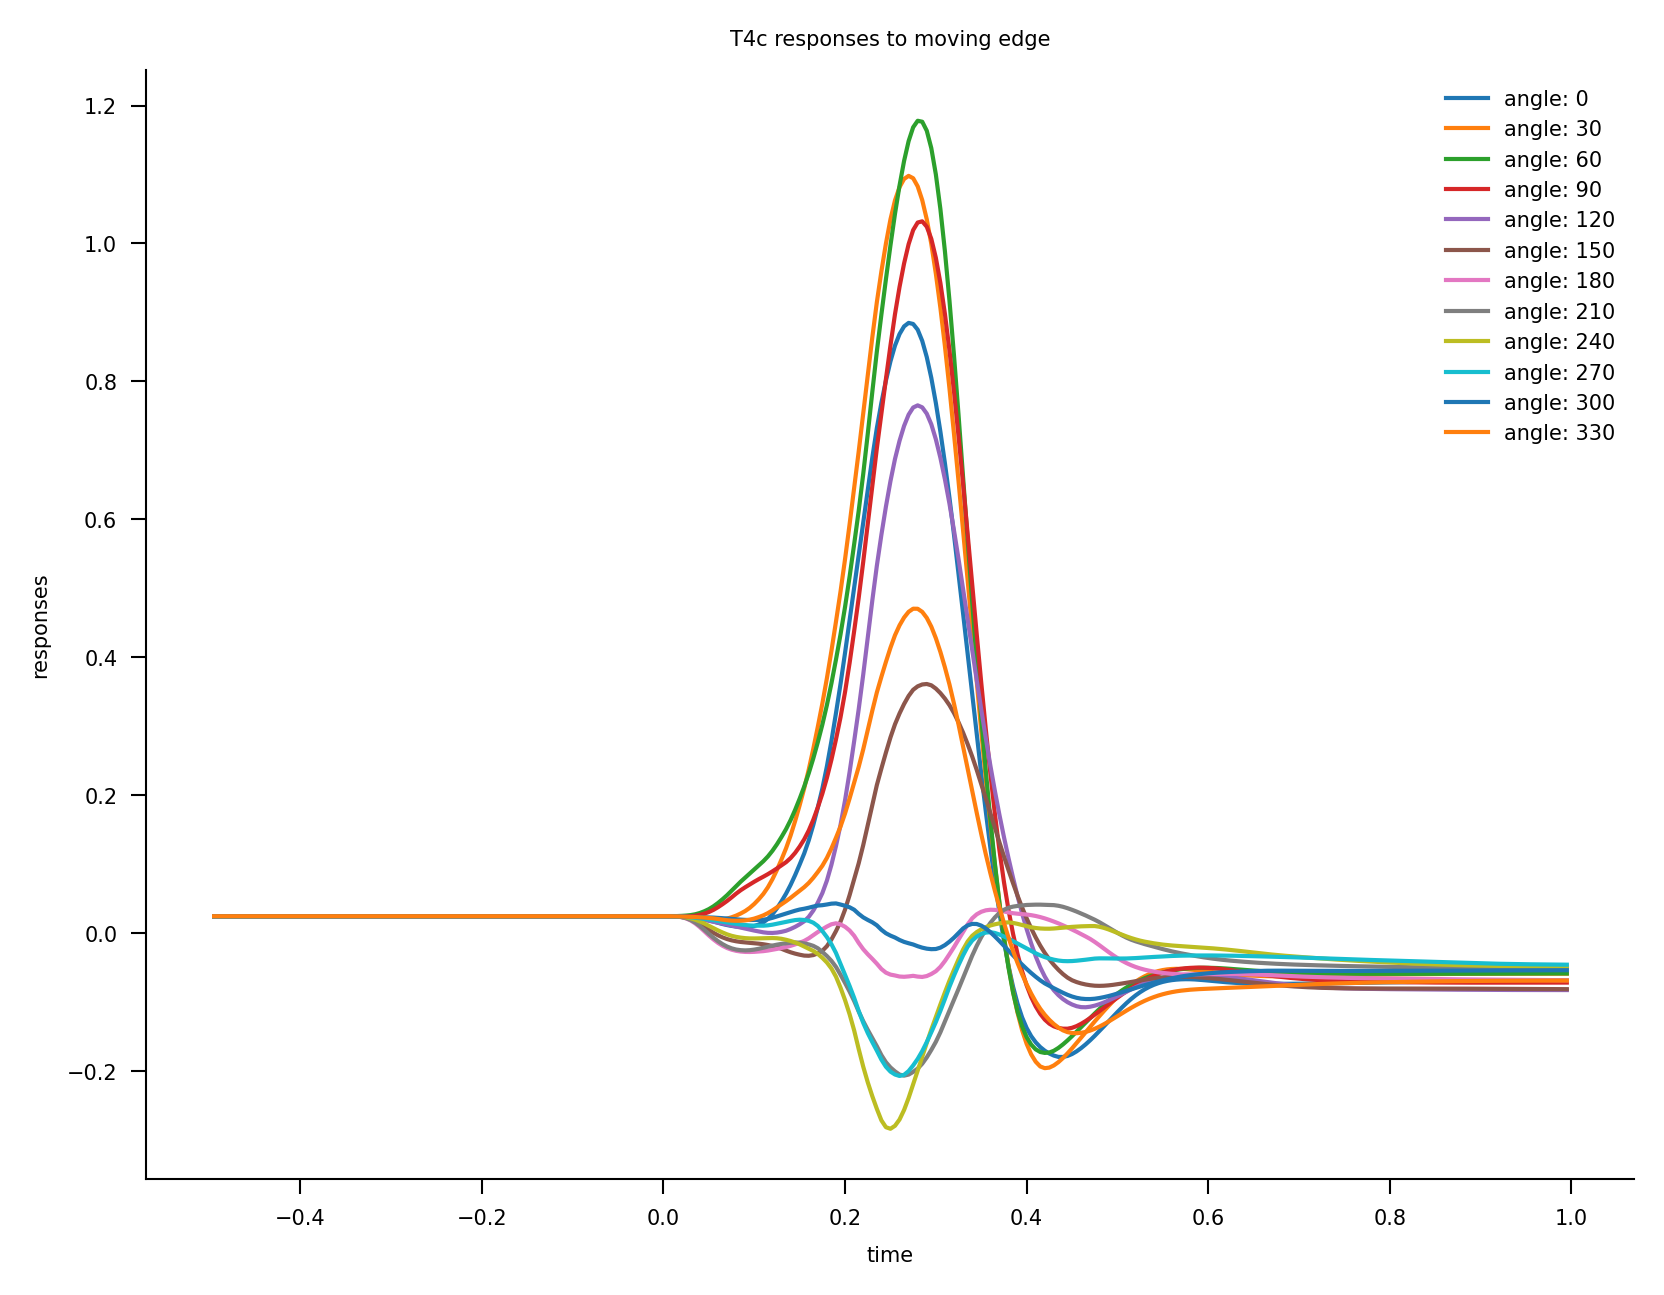

In [9]:
stims_and_resps["responses"].custom.where(
    cell_type="T4c", intensity=1, time=">-0.5,<1.0"
).custom.plot_traces(x="time", legend_labels=["angle"])
ax = plt.gca()
ax.set_title("T4c responses to moving edge")

### Direction selectivity index (DSI)

The **Direction Selectivity Index (DSI)** quantifies a cell's preference for stimuli moving in a particular direction.

The DSI is derived from the following steps:
1. Obtain the neuron's peak responses to stimuli moving in different directions $\theta$ and at different speeds $S$.
2. Rectify these peak responses to ensure they are non-negative.
3. Compute the DSI using the equation:

$$
DSI_{t_i}(I) = \frac{1}{\lvert S \rvert} \sum_{S \in S} \left\lvert \frac{\sum_{\theta \in \Theta} r^{peak}_{t_{central}}(I, S, \theta) e^{i\theta}}{\max_{I \in I} \left\lvert \sum_{\theta \in \Theta} r^{peak}_{t_{central}}(I, S, \theta) \right\rvert} \right\rvert
$$

Where:
- $DSI_{t_i}(I)$ is the Direction Selectivity Index for cell type $t_i$ at stimulus intensity $I$.
- $\lvert S \rvert$ is the number of different speeds at which stimuli are moved.
- $r^{peak}_{t_{central}}(I, S, \theta)$ represents the rectified peak response of the central cell in hexagonal space of a cell type, for a given stimulus intensity $I$, speed $S$, and direction $\theta$.
- $\theta$ is varied across all tested directions $\Theta$.
- $e^{i\theta}$ introduces the directional component by weighting the response by the complex exponential of the angle of movement.
- The denominator normalizes the responses, ensuring that DSI values range from 0 to 1.

The DSI values range from 0 to 1. A DSI of 0 indicates no directional preference, while a DSI of 1 indicates a strong preference for a specific direction.

For the T4c cell plotted before, we can see that it preferentially responds to ON edges moving at an angle of 60 degrees, so we expect to see a large DSI.

 We compute the DSI with `flyvis.analysis.direction_selectivity_index`.

In [10]:
from flyvis.analysis.moving_bar_responses import direction_selectivity_index

In [11]:
# get DSI for T4c cell
dsis = direction_selectivity_index(stims_and_resps)
print(f"T4c DSI: {dsis.custom.where(cell_type='T4c', intensity=1).item():.2f}")

T4c DSI: 0.63


We compute the preferred direction of the cell with `flyvis.analysis.preferred_direction` (this is the direction that the tuning lobe points towards). We would expect the preferred direction to be around 60 degrees based on the response traces.

In [12]:
from flyvis.analysis.moving_bar_responses import preferred_direction

In [13]:
pds = preferred_direction(stims_and_resps)
print(
    f"T4c preferred direction: {pds.custom.where(cell_type='T4c', intensity=1).item() / np.pi * 180:.2f} degrees"
)

T4c preferred direction: 56.24 degrees


We can also inspect the direction selecity of a cell type visually, by plotting the angular tuning with `plot_angular_tuning`.

Here we see clearly how the cell is tuned to stimuli moving at a 60 degree angle.

In [14]:
from flyvis.analysis.moving_bar_responses import plot_angular_tuning

(<Figure size 300x300 with 1 Axes>, <PolarAxes: >)

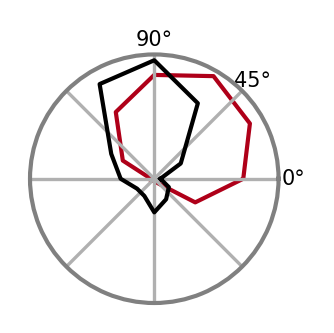

In [15]:
plot_angular_tuning(stims_and_resps, cell_type="T4c", intensity=1)

### DSI  and tuning curve correlation

With the `dsi()` function we can also compute DSIs for every cell type at once. Since the selectivity of some cell types have been determined experimentally, we can then compare our model to experimental findings by computing the correlation between the model DSIs for known cell types with their expected motion selectivity.

In [16]:
from flyvis.analysis.moving_bar_responses import dsi_correlation_to_known

In [17]:
dsi_corr = dsi_correlation_to_known(direction_selectivity_index(stims_and_resps)).median()

In [18]:
print(f"DSI correlation = {dsi_corr.item(): .2f}")

DSI correlation =  0.89


Further, for certain cell types, their actual tuning curves have also been measured experimentally, so we can correlate our model cell's tuning to the true values. For T4c, the cell is known to tune to stimuli moving at 90 degrees, so the correlation should be relatively high.

In [19]:
from flyvis.analysis.moving_bar_responses import correlation_to_known_tuning_curves

In [20]:
corrs = correlation_to_known_tuning_curves(stims_and_resps)

In [21]:
print(
    f"T4c tuning curve correlation = {corrs.custom.where(cell_type='T4c', intensity=1).squeeze().item():.2f}"
)

T4c tuning curve correlation = 0.54


In fact, tuning curves for all T4 and T5 cells have been measured, so we can compute the correlation for all 8 cell types.

In [22]:
t4_corrs = corrs.custom.where(cell_type=["T4a", "T4b", "T4c", "T4d"], intensity=1)
t5_corrs = corrs.custom.where(cell_type=["T5a", "T5b", "T5c", "T5d"], intensity=0)

In [23]:
print(
    f"T4 tuning curve correlations: {t4_corrs.cell_type.values}\n{t4_corrs.squeeze().values}"
)

T4 tuning curve correlations: ['T4a' 'T4b' 'T4c' 'T4d']
[0.93699976 0.71944945 0.53721791 0.85661054]


In [24]:
print(
    f"T5 tuning curve correlations: {t5_corrs.cell_type.values}\n{t5_corrs.squeeze().values}"
)

T5 tuning curve correlations: ['T5a' 'T5b' 'T5c' 'T5d']
[0.84125431 0.90320938 0.94956469 0.90100506]


So, the model yields accurate predictions for all T4 and T5 cell types.

## Ensemble responses

Now we can compare motion selectivity properties across an ensemble of trained models. First we need to again simulate the network responses.

In [25]:
from flyvis import EnsembleView

ensemble = EnsembleView(results_dir / "flow/0000")
# choose best 10
ensemble = ensemble[ensemble.argsort()[:10]]

Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-12-08 19:36:33] ensemble:166 Loaded 50 networks.


Loading ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

[2024-12-08 19:36:37] ensemble:166 Loaded 10 networks.


In [26]:
%%capture
stims_and_resps = ensemble.moving_edge_responses(dataset=dataset)

### Response traces

We can once again plot response traces for a single cell type. 

We subtract the initial value of each trace and divide by the max as the network neuron activities are in arbitrary units. 

We plot only T4c responses to ON edges moving at a 90-degree angle.

In [27]:
responses = (
    stims_and_resps["responses"]
    - stims_and_resps["responses"].custom.where(time=0).values
)

In [28]:
responses = responses / np.abs(responses).max(("sample", "frame"))

<Axes: xlabel='time', ylabel='responses'>

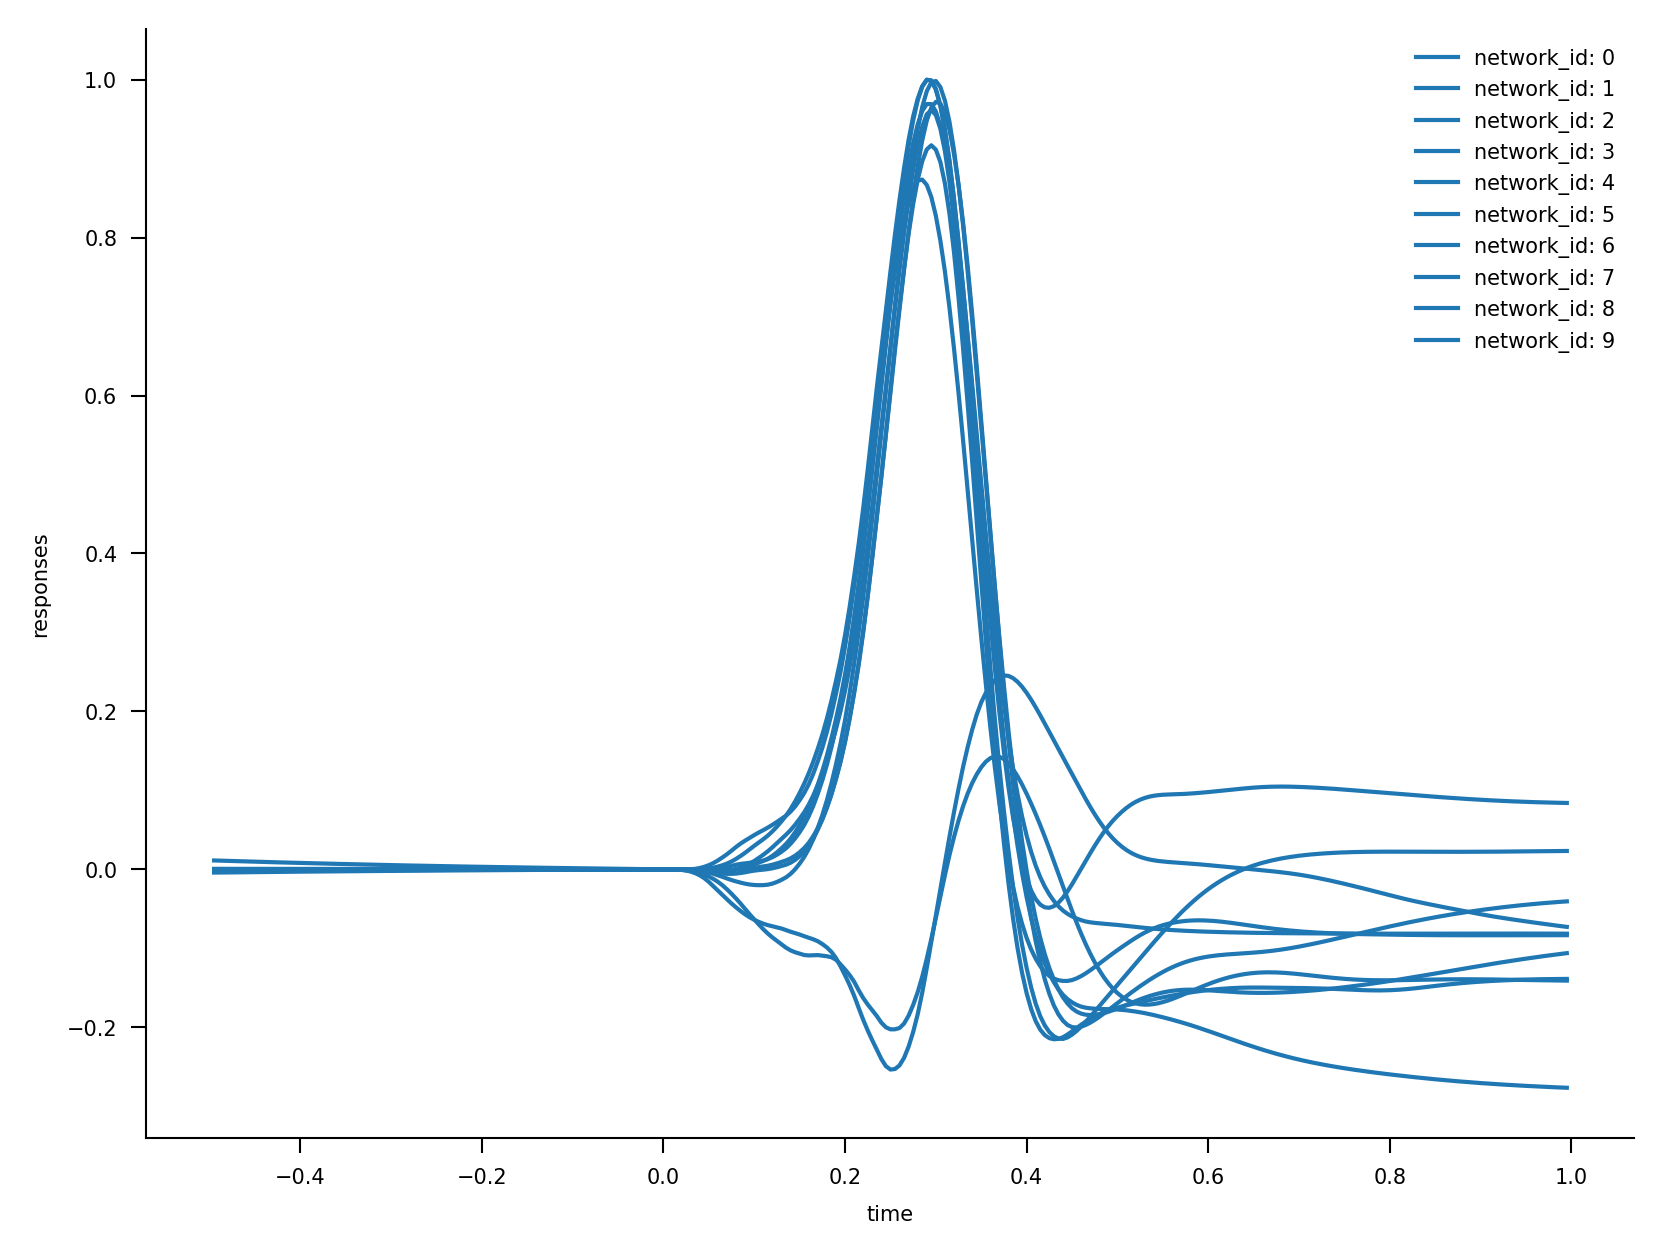

In [29]:
responses.custom.where(
    cell_type="T4c",
    intensity=1,
    time=">-0.5,<1.0",
    angle=90,
).custom.plot_traces(
    x="time", plot_kwargs=dict(color="tab:blue"), legend_labels=["network_id"]
)

Though for most networks T4c responses are correctly predicted to the stimuli, there are some networks in the ensemble with different responses.

### Direction selectivity index (DSI)

We can also compute direction selectivity indices for each network in the ensemble.

In [30]:
dsis = direction_selectivity_index(stims_and_resps)

Text(0, 0.5, 'Number of networks')

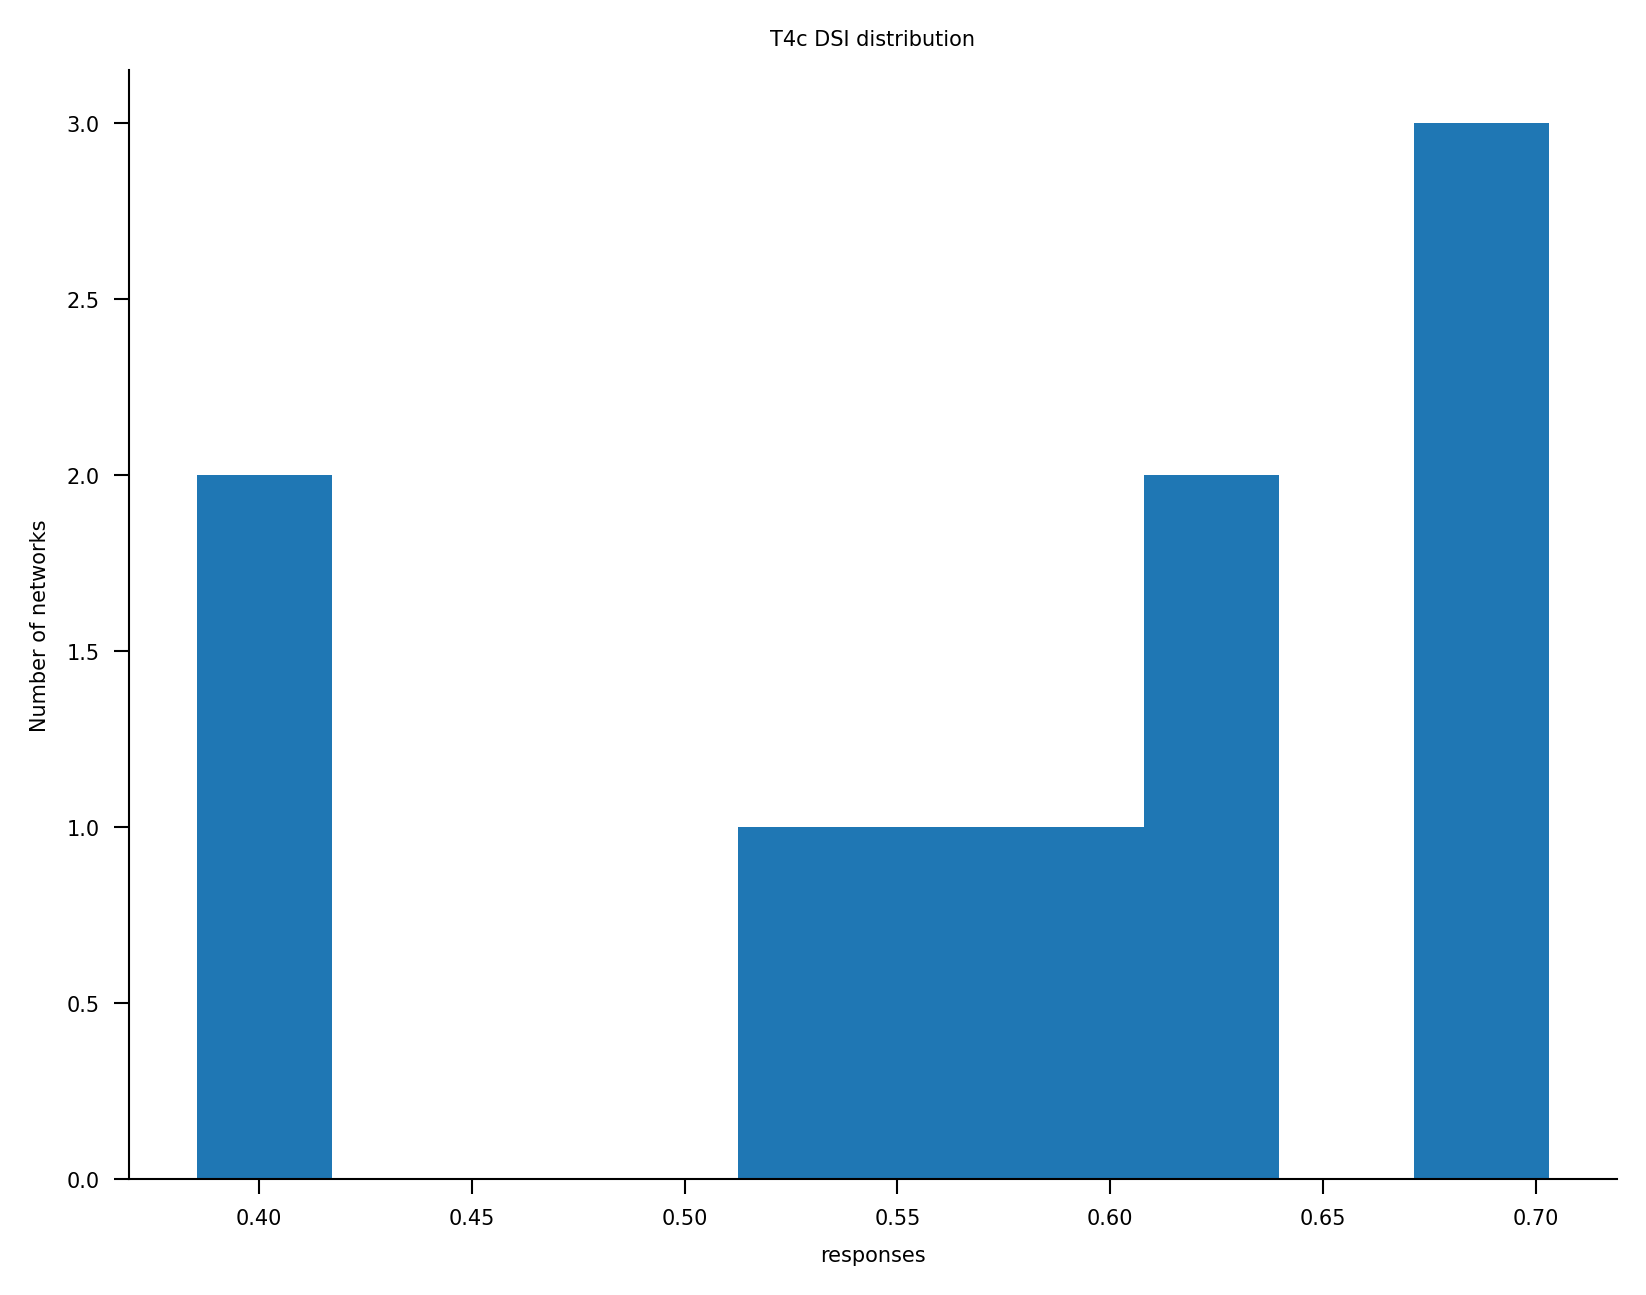

In [31]:
dsis.custom.where(cell_type="T4c", intensity=1).plot.hist()
ax = plt.gca()
ax.set_title("T4c DSI distribution")
ax.set_ylabel("Number of networks")

Most networks in this group recover some direction selectivity for T4c. We can also plot the distribution of DSIs per cell type for both ON and OFF-edge stimuli across the ensemble.

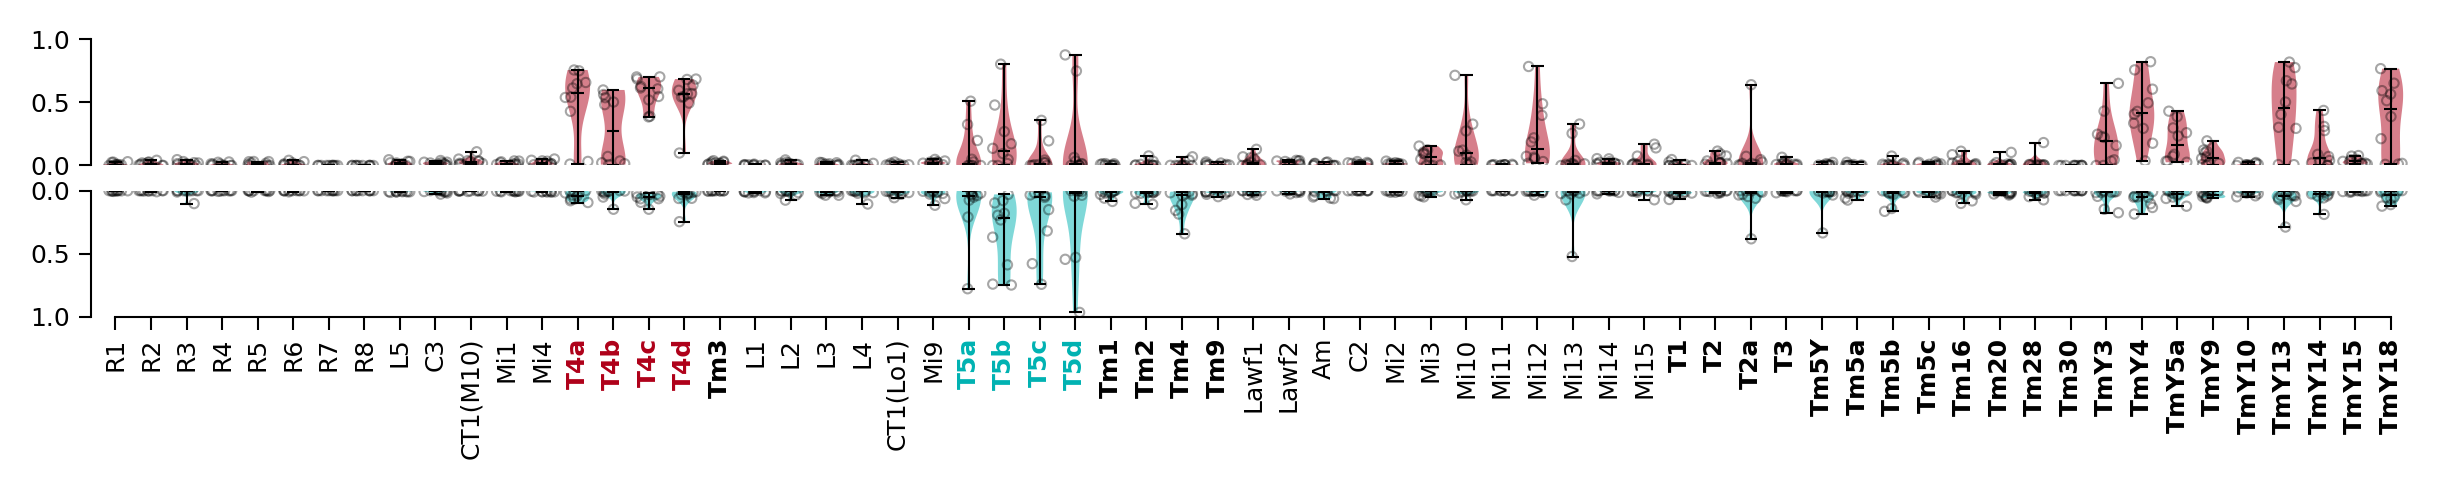

In [32]:
from flyvis.analysis.moving_bar_responses import dsi_violins_on_and_off

fig, ax = dsi_violins_on_and_off(
    dsis,
    dsis.cell_type,
    bold_output_type_labels=True,
    output_cell_types=ensemble[ensemble.names[0]]
    .connectome.output_cell_types[:]
    .astype(str),
    figsize=[10, 1.2],
    color_known_types=True,
    fontsize=6,
    scatter_best_index=0,
    scatter_best_color=plt.get_cmap("Blues")(1.0),
)

### DSI correlation

Lastly, we look at the correlations to ground-truth DSIs and tuning curves across the ensemble. This provides us with a high-level understanding of the accuracy of known motion tuning predictions. 

In [33]:
dsi_corr = dsi_correlation_to_known(direction_selectivity_index(stims_and_resps))

In [34]:
tuning_corrs = correlation_to_known_tuning_curves(stims_and_resps)

In [35]:
t4_corrs = (
    tuning_corrs.custom.where(cell_type=["T4a", "T4b", "T4c", "T4d"], intensity=1)
    .median("neuron")
    .squeeze()
)
t5_corrs = (
    tuning_corrs.custom.where(cell_type=["T5a", "T5b", "T5c", "T5d"], intensity=0)
    .median("neuron")
    .squeeze()
)

In [36]:
dsi_corr.shape, t4_corrs.shape, t5_corrs.shape

((10,), (10,), (10,))

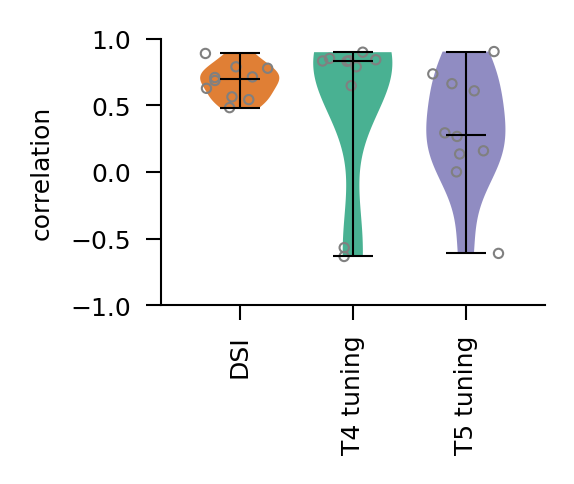

In [37]:
from flyvis.analysis.visualization.plots import violin_groups

fig, ax, *_ = violin_groups(
    np.stack([dsi_corr.values, t4_corrs.values, t5_corrs.values], axis=0)[:, None, :],
    ["DSI", "T4 tuning", "T5 tuning"],
    ylabel="correlation",
    figsize=(1.8, 1.5),
    ylim=(-1, 1),
    colors=[
        plt.get_cmap("Dark2")(0.125),
        plt.get_cmap("Dark2")(0),
        plt.get_cmap("Dark2")(0.25),
    ],
    color_by="experiments",
    scatter_edge_color="gray",
    scatter_radius=5,
    violin_alpha=0.8,
)

<!-- ... Models in general have very good match to known single-neuron tuning properties, with median correlation around $0.8$. -->